In [1]:
import numpy as np
import matplotlib.pyplot as plt

---
### Load diabetes data set.

In [2]:
from sklearn import datasets
import pandas as pd

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
y -= y.mean()
features = "age sex bmi map tc ldl hdl tch ltg glu".split()
diabetesdf = pd.DataFrame(diabetes.data, columns=features)
diabetesdf.tail()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930
441,-0.045472,-0.044642,-0.073030,-0.081414,0.083740,0.027809,0.173816,-0.039493,-0.004220,0.003064


---
### OLS regression

In [4]:
from sklearn.linear_model import LinearRegression

olsmodel = LinearRegression()
olsmodel.fit(X, y)
yfit = olsmodel.predict(X)

print("beta:", olsmodel.coef_)
print("MSE:", np.mean((y - yfit)**2))
print("R^2:", olsmodel.score(X, y))

beta: [ -10.01219782 -239.81908937  519.83978679  324.39042769 -792.18416163
  476.74583782  101.04457032  177.06417623  751.27932109   67.62538639]
MSE: 2859.6903987680657
R^2: 0.5177494254132934


---
### Ridge regression with cross validation

Error to be minimized $= SSE + \lambda \sum_j \beta_j^2$

$\lambda$ is refered to as a hyperparameter.

We'll use cross validation to figure out what it should be.

alpha: 0.004094915062380423
beta: [  -8.49508631 -237.25073982  521.05537865  322.45164462 -545.10254784
  280.74496815   -7.54438643  148.06050222  656.87377116   69.36047931]
MSE: 2862.0592638039234
R^2: 0.5173499463210277


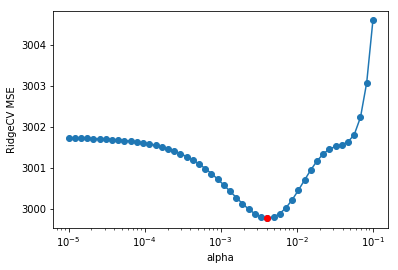

In [6]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-5, -1, 50)  # 10^-5 ... 10^-1
ridgecvmodel = RidgeCV(alphas, store_cv_values=True)
ridgecvmodel.fit(X, y)
yfit = ridgecvmodel.predict(X)

print("alpha:", ridgecvmodel.alpha_)
print("beta:", ridgecvmodel.coef_)
print("MSE:", np.mean((y - yfit)**2))
print("R^2:", ridgecvmodel.score(X, y))

MSE_vs_alpha = ridgecvmodel.cv_values_.mean(axis=0)
idx = np.argmin(MSE_vs_alpha)
plt.plot(alphas, MSE_vs_alpha, 'o-')
plt.plot(alphas[idx], MSE_vs_alpha[idx], 'ro')
plt.xlabel('alpha')
plt.ylabel('RidgeCV MSE');
plt.semilogx();

---
### Let's do ridge regression with 10-fold cross validation by hand.

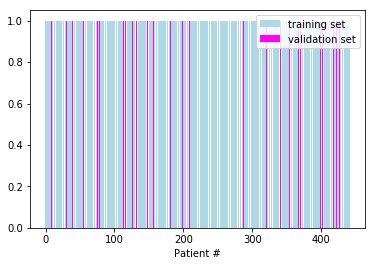

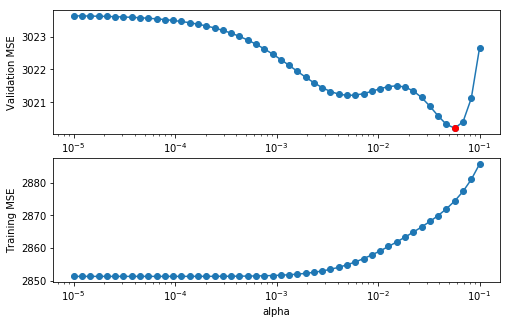

In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)

alphas = np.logspace(-5, -1, 50)  # 10^-5 ... 10^-1
MSE_train_vs_alpha = []
MSE_val_vs_alpha = []
first = True
for alpha in alphas:
    # Perform 10-fold CV for each alpha and store the resulting average MSE for each of the 10 training and validation sets.
    MSE_train_cv = []
    MSE_val_cv = []
    for train_index, val_index in kf.split(X, y):
        # plot data split only on the first time
        if first:
            plt.figure()
            plt.bar(train_index, np.ones(train_index.shape), color='lightblue', label='training set')
            plt.bar(val_index, np.ones(val_index.shape), color='magenta', label='validation set')
            plt.xlabel('Patient #')
            plt.legend()
            first = False
        
        # split data into training and validation sets
        X_train = X[train_index, :]
        X_val = X[val_index, :]
        y_train = y[train_index]
        y_val = y[val_index]
        
        # new model for each split
        model = Ridge(alpha=alpha)
        
        # fit model to training set
        model.fit(X_train, y_train)
        
        # get error from training set
        y_train_fit = model.predict(X_train)
        MSE_train_cv.append(np.mean((y_train - y_train_fit)**2))
        
        # get error from test set
        y_val_fit = model.predict(X_val)
        MSE_val_cv.append(np.mean((y_val - y_val_fit)**2))
    
    MSE_train_vs_alpha.append(np.array(MSE_train_cv).mean())
    MSE_val_vs_alpha.append(np.array(MSE_val_cv).mean())

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
idx = np.argmin(MSE_val_vs_alpha)
ax[0].plot(alphas, MSE_val_vs_alpha, 'o-')
ax[0].plot(alphas[idx], MSE_val_vs_alpha[idx], 'ro')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('Validation MSE');
ax[0].semilogx();

ax[1].plot(alphas, MSE_train_vs_alpha, 'o-')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('Training MSE');
ax[1].semilogx();

### OK, now we have selected a $\lambda$. What are the best weights for each of our features? For that, let's refit all of our data using our selected model (i.e. our selected $\lambda$).

In [20]:
idx = np.argmin(MSE_val_vs_alpha)
best_alpha = alphas[idx]

ridgekfoldmodel = Ridge(alpha=best_alpha)
ridgekfoldmodel.fit(X, y)
yfit = ridgekfoldmodel.predict(X)

print("alpha:", best_alpha)
print("beta:", ridgekfoldmodel.coef_)
print("MSE:", np.mean((y - yfit)**2))
print("R^2:", ridgekfoldmodel.score(X, y))

alpha: 0.05689866029018293
beta: [  -2.0879863  -219.24125985  505.09647716  310.08718329 -125.78616268
  -45.45275601 -178.41710641  113.70971831  475.73642691   80.3685477 ]
MSE: 2880.789670644095
R^2: 0.5141913003834091


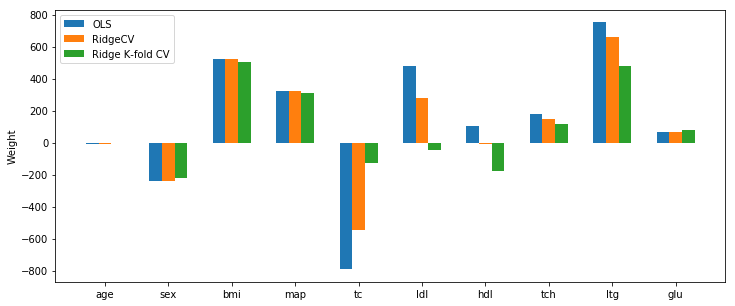

In [21]:
plt.figure(figsize=(12, 5))
xticks = np.arange(len(features))
plt.bar(xticks-0.2, olsmodel.coef_, width=0.2, label='OLS')
plt.bar(xticks, ridgecvmodel.coef_, width=0.2, label='RidgeCV')
plt.bar(xticks+0.2, ridgekfoldmodel.coef_, width=0.2, label='Ridge K-fold CV')
plt.xticks(xticks, labels=features)
plt.ylabel('Weight')
plt.legend();

---
### K-fold cross validation wrapped up nice and neat for you.

In [33]:
from sklearn.model_selection import cross_validate

model = Ridge(alpha=best_alpha)
results = cross_validate(model, X, y, cv=10, return_train_score=True)

results['test_score'], results['train_score']

(array([0.42159257, 0.16844213, 0.3580036 , 0.51260807, 0.28492814,
        0.51426355, 0.38824614, 0.48444792, 0.396502  , 0.52513249]),
 array([0.44340162, 0.45618259, 0.45419548, 0.42422853, 0.46216348,
        0.42519585, 0.44992335, 0.44496173, 0.44986043, 0.43003492]))

In [44]:
model = Ridge(alpha=best_alpha)
results = cross_validate(model, X, y, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

results['test_score'], results['train_score']

(array([-2660.10810183, -2807.77514131, -3368.81621082, -2854.08114404,
        -3483.41952682, -2873.28932119, -3617.91296518, -2297.81891449,
        -4155.32700595, -1855.2051948 ]),
 array([-2920.36425809, -2893.8644532 , -2835.77048901, -2892.4101619 ,
        -2813.90428447, -2893.44439421, -2813.98800069, -2946.78013906,
        -2740.35449868, -3005.87443486]))

In [60]:
alphas = np.logspace(-5, -1, 50)  # 10^-5 ... 10^-1
MSE_train_vs_alpha = []
MSE_val_vs_alpha = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    results = cross_validate(model, X, y, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    MSE_train_vs_alpha.append(-results['train_score'].mean())
    MSE_val_vs_alpha.append(-results['test_score'].mean())

0.047148663634573894

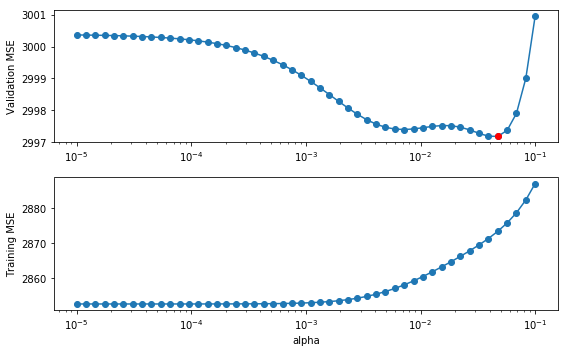

In [63]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
idx = np.argmin(MSE_val_vs_alpha)
ax[0].plot(alphas, MSE_val_vs_alpha, 'o-')
ax[0].plot(alphas[idx], MSE_val_vs_alpha[idx], 'ro')
ax[0].set_ylabel('Validation MSE');
ax[0].semilogx();

ax[1].plot(alphas, MSE_train_vs_alpha, 'o-')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('Training MSE');
ax[1].semilogx();

fig.tight_layout();

alphas[idx]

---
### Compare with OLS.

In [56]:
model = LinearRegression()
results = cross_validate(model, X, y, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

print("train MSE:", -results['train_score'].mean())
print("test MSE:", -results['test_score'].mean())

train MSE: 2852.5566887595296
test MSE: 3000.3810328390514


---
### More ways to wrap things up nicely for you.

In [64]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': np.logspace(-5, -1, 50)}
ridgemodel = Ridge()
cvmodel = GridSearchCV(ridgemodel, params, cv=10, scoring='neg_mean_squared_error')
cvmodel.fit(X, y)
cvmodel.best_params_['alpha']

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.039069399370546126